# Advanced Risk Management – Assignment 1

**Deadline**:  28 February 2022, 13.00h.

| |Name |Student number|Email|
|:-|:----|:-------------|:----|
|1.|Zhuohang Li  | 14205912  | zhuohang.li2@student.uva.nl |

## Introduction
The file `raw_data_2021.xlsx` contains daily data (January 2000 – January 2021, or a sub-period), for a number of international stock market indices, on the closing price and the daily realized variance RV (obtained from 5-minute returns).
A list of the included indices is given on the website of the data provider, see
https://realized.oxford-man.ox.ac.uk/data/assets. In this assignment, you are asked to estimate, test and compare several conditional volatility models for one of the indices in terms of their in-sample fit and their out-of-sample forecast quality.

## Question 1: Load, clean, and display data
First, install and import the relevant libraries:

In [1]:
# !pip install arch            # uncomment for installing the arch package 
import numpy as np
import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns

Next, import the data and obtain the returns for all indices. Uncomment and adapt the lines necessary to mount the drive and change the path.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# path = '/content/drive/...'    # change path to your working directory
# os.chdir(path)

df = pd.read_excel('raw_data_2021.xlsx') # imports the data

Now we transform the data and put the data belonging to our favorite stock index in a DateFrame for further manipulation by running the code below. Pick your favorite index from the list of indices linked to above by adapting the 'Symbol' name below.

In [3]:
df['Date'] = df['Date'].str[0:10] # remove irrelevant parts of date string

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d') # transform date strings to datetime 
df = df.set_index(['Date']) # set index of DataFrame to the date column

df['R'] = np.log(df['close_price']) - np.log((df['close_price']).shift(1)) # calculate close-to-close returns
df.dropna() # drop N/A entries

sel = df['Symbol']=='.FCHI'   # Boolean array to select index;
                       # change '.ABC' to chosen index symbol, e.g., '.FCHI'
    
R = 100 * (df['R'].loc[sel])['2000-01-04':] # transform returns to percentages (recommended for GARCH package) and remove first row from returns 

RV = 100**2 * (df['rv5'].loc[sel])['2000-01-04':] # transform realized variances as well
RV = RV / RV.mean() / (R**2).mean() # rescale realized variances to account for close-to-open news
RV = RV**0.5 # transform realized variance to realized volatility

Display a line graph of the returns, the realized volatility, and the standardizes returns (the return divided by its realized volatility).  Calculate the skewness and kurtosis of the returns and the standardized returns. Summarize your findings. What can you conclude?

,Return,Standardize Return
Skewness,-0.223648,0.175293
Kurtosis,5.838868,-0.002004


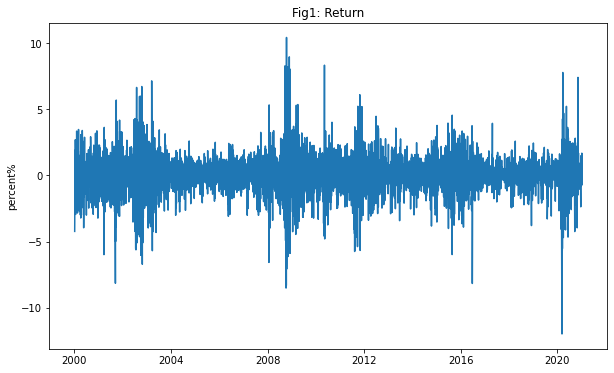

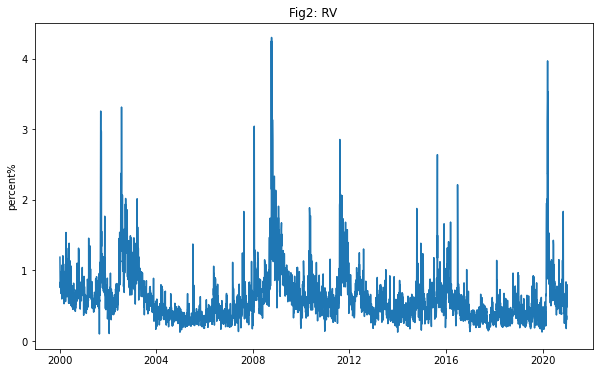

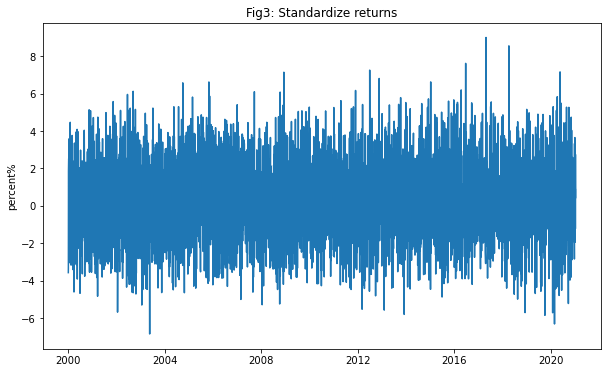

In [4]:
plt.figure(figsize=(10,6)) # plot of return
plt.ylabel('percent%')
plt.title('Fig1: Return');
plt.plot(R);

plt.figure(figsize=(10,6)) # plot of realized volatility
plt.ylabel('percent%')
plt.title('Fig2: RV')
plt.plot(RV);

Z = R / RV # standardizes returns
plt.figure(figsize=(10,6))
plt.ylabel('percent%')
plt.title('Fig3: Standardize returns')
plt.plot(Z);# plot standardized return

sk1 = R.skew()# skewness of return 
kur1 = R.kurtosis()# kurtosis of return
sk2 = Z.skew()# skewness of standardized return 
kur2 = Z.kurtosis() #kurtosis of standardized return
pd.DataFrame(index = ['Skewness','Kurtosis'],
             columns=['Return','Standardize Return'],
             data=([sk1,sk2],[kur1,kur2]))# display in a dataframe

Discussion of results: [10 pts.]# 

1.Standardized return has less skewness comparing with log return, at the same time it is right-skewed while  original log return is left-skewed. So left side or price-drop side extreme event is more likely to happen in original rerturn. Right side or price-jump side extreme event is more likely to happen in standardized return. Standardized return almost has zero excess kurtosis. On then contrary,log return has 5.84 excess kurtosis, which means original log return distribution has peak in the middle and fatter tailes. In conclusion, standardized return has higher normality while log return distribution has non-normality characteristics which is in agreement with the stylized facts.

2.As fig 1 shows, the mean of return seems clost to zero and return series seems has very little autocorrelation. Fig2 shows that volatility clustering, higher volatility is more likely to follow high volatility, vice versa. They comform with the stylized facts we learned.

3.Fig3 shows, standardized return looks very like white noise. Zero mean and little autocorrelation. Better Normality.

4.In a word: return series shouldn't be assumed to be normal distribution then modeling base on that assumption.

## Question 2: Fitting a t distribution

It seems the returns have heavy tails. One way of modelling this property is to assume the returns are t distributed. 
1. The code below fits a t ditribution to the data. Fit a t distribution to the data, assuming returns have mean zero. Provide the estimated value of the degrees of freedom parameter $d$ and discuss your result. 
2. Using the formula on Slide 16 of Week 3, estimate the $p$th quantile of the standardized t distribution with degrees of freedom parameter $d$. Use $p=0.01$. Compare this value to the $p$th quantile of the standard normal distribution.
3. If we assume that the volatility is constant over time (an unrealistic assumption, but still one we can make), the quantiles can be used to obtain VaR forecasts for both distributions (see again Slide 16 of Week 3). Obtain the VaR forecasts and compute the percentage of exceedences. Use the standard deviation of the returns to estimate the constant volatility $\sigma$.

Discuss your findings for each step.

In [5]:
d,location,scale = stats.t.fit(R,floc=0)
print('degree of freedom:',round(d,2))

degree of freedom: 3.19


Discussion: 

Here we found that t-distribution's degree of freedom of log return under Maximum Likelihood Estimate is 3.19, it's higher than 2 therefore luckily we could well defined standardized t-distribution or the density function of standardized t-distribution will have zero as denominator. But d less than 4, the t-distribution we fit has a high skewness.

In [6]:
pquantile_t = np.sqrt((d-2)/d) * stats.t.ppf(0.01,d,loc=0,scale=1) # returns the p-th quantile of the STANDARDIZED t distribution with degrees of freedom d, mean zero, and scale sd
pquantile_n = stats.norm.ppf(0.01) # returns the p-th quantile of the standard normal distribution
pd.DataFrame(index = ['t_distribution','standard normal distribution'],
                   data = [pquantile_t,pquantile_n],columns=[''])# comparsion of p_quantiles from t distribution and standard mormal distribution


,
t_distribution,-2.645743
standard normal distribution,-2.326348


Discussion: Here we found that this t-distribution has lower quantile given p=0.01, it will lies below diagnal in QQ plot at that point. And it has heavier tails than standard normal distribution

In [7]:
sigma = np.std(R) # returns the standard deviation of the Return series
constantseries = 0 * R + sigma # derived a constant volatility series across time
VaR_t = -constantseries * pquantile_t # VaR given volatility constant
exceedences = (R < -VaR_t).sum()# count how many records less than VaR, it is the number of exceedences dates
T = len(R) # total nubmer of records
per_of_exct = ( exceedences/ (T))# compute the percentage of exceedences
print('percentage of t distribution exceedences:',round(per_of_exct,4))#results display here

VaR_n = -constantseries * pquantile_n # VaR given volatility constant under normal distribution
exceedences = (R < -VaR_n).sum()# count how many records less than VaR, it is the number of exceedences
T = len(R) # total nubmer of records
per_of_exctn = ( exceedences/ (T))# compute the percentage of exceedences
print('percentage of norma distribution exceedences:',round(per_of_exctn,4))#results display here

percentage of t distribution exceedences: 0.0136
percentage of norma distribution exceedences: 0.0194


Discussion of results  [10 pts]: #

These two percentage of exceedences are around 0.01,which is approximately the threhold probability we defined. While t distribution has a better estimation since percentage of exceedences from t-distribution is much closer to 0.01 we defined before. Given the fact that return series has heavy tails, t-distribution is better than normal distribution for modeling the VaR

## Question 3: Extreme value theory

We can also use Extreme Value Theory to estimate VaR.

1. The simplest setting uses the formula for VaR on Slide 21 of Week 3: $\text{VaR}^p_{t+1} = \sigma_{t+1} u\bigl( \frac{p}{T_u/T}\bigr)^\xi$, where $u$ denotes the threshold, and $T_u$ denotes the number of losses exceeding the threshold. Use $T_u = 0.05 T$, being 5\% of the total data. Choose $u$ equal to the 95% percentile of the losses. Estimate $\xi$ with the Hill estimator. Describe which observations are used in this method (using the threshold). Also discuss what the estimate of $\xi$ implies.

2. Set $\sigma_{t+1} = \sigma$, for all time periods $t$, and let $\sigma$ denote the value found in Question 2. Obtain an estimate of VaR, at $p=0.01$, and calculate the percentage of exceedences.



In [8]:
T = len(R) # obtain length of return series
Tu = int(np.floor(0.05 * T)) # returns closest integer smaller than number 0.05*T
u = R.quantile(95/100) # obtain 0.95th percentile of a series
# # Hill estimator
series_sorted = np.flipud(np.sort(R))  # sort series in descending order, largest values first for return series
xi_hill = np.mean(np.log(series_sorted[:Tu-1]/u)) # hill estimator generation
xi_hill 

0.3676022131266843

Discussion:

Here we used the values larger than the threhold of u, which is 0.95 quantile of Return series, as observations.In addition, positive xi_hill implies heavy tails

In [9]:
p = 0.01
sigma2 = 0 * R + sigma # assume 𝜎𝑡+1=𝜎, conditional volatility equal to unconditional volatility, therefore the volatility series is constant
VaR2 = sigma2 * u * (p / (Tu/T))**(-xi_hill) # VaR with EVT theoty
VaR2

Date
2000-01-04    5.3365
2000-01-05    5.3365
2000-01-06    5.3365
2000-01-07    5.3365
2000-01-10    5.3365
               ...  
2021-01-04    5.3365
2021-01-05    5.3365
2021-01-06    5.3365
2021-01-07    5.3365
2021-01-08    5.3365
Name: R, Length: 5358, dtype: float64

In [10]:
exc = (R < -VaR2).sum() # the number of exceedences date when return worse than -VaR 
T = len(R)
per_of_exc2 = (exc/ (T)) # percentage of exceedences
print('percentage of exceedences:',round(per_of_exc2,4))

percentage of exceedences: 0.0049


## Question 4: Adding time-varying volatility
In Question 1 we've found that the standardized returns display no excess kurtosis. The standardization was carried out using ex post realized volatility: We used the realized volatility observed at the end of the day $t$ to standardize the return at the end of time $t$. To use the realized volatility for Value-at-Risk forecasting we must create ex ante forecasts of realized volatility.

1. We use a simple AR model to create Value-at-Risk forecasts. AR models can be estimated using OLS, by regressing the current value of RV on its lag and a constant (Use smf.ols() and don't forget to lag a regressor using d.shift(1).) Plot the ex post RV and its forecast together (Add the forecast to the DataFrame dfregress, dfregress['forecast'] = forecast, and use .plot()). Discuss your findings.

2. Create standardized return shocks (or simply shocks) by dividing the return by the volatility forecast from the AR(1) model and estimate the kurtosis.

3. Estimate VaR forecasts for the shocks using the standardized t distribution, standardized normal distribution and EVT theory. Don't forget to multiply the forecasts by the standard deviation of the shocks, in case of the standardized t and normal distribution. This is important, because the shocks have standard deviation quite far from 1. Then transform the VaR forecasts for shocks to VaR forecasts for returns by multiplying the VaR forecast for shocks by the realized volatility forecast.  Plot the VaR forecasts for the returns together in a plot (You can use the DataFrame trick again). (Note: you must estimate the standard deviation of the shocks when you fit the t distribution, because these shocks might not have standard deviation close to one. The same holds for the normal distribution.)

3. Calculate the percentage of exceedences. Discuss your findings. Also relate your results to ealier questions. Would other tests be more helpful in finding differences between VaR forecasts based on constant volatility and time-varying volatility models?

In [11]:
dfregress = pd.DataFrame({'Y': RV, 'X': RV.shift(1)}) # create a Dataframe that contains both return series and return lagged series (needed for smf.ols)
model = smf.ols('Y ~ X', data=dfregress) # generate a AR(1) model of Y on the intercept and X that is the 1-period lagged Y

result = model.fit()
print(result.summary())# OLS results display
parametervector = np.array(result.params)
forecast = np.array([RV**0, RV.shift(1)]).transpose().dot(parametervector) # get the forecast of RV
dfregress['forecast'] = forecast# Add RV forecast into dfregress dataframe

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                 1.085e+04
Date:                Mon, 28 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:09:20   Log-Likelihood:                 877.92
No. Observations:                5357   AIC:                            -1752.
Df Residuals:                    5355   BIC:                            -1739.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1096      0.006     19.903      0.0

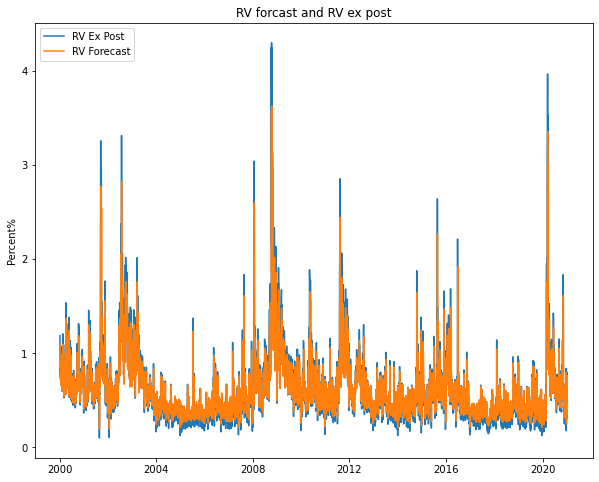

In [12]:
#plot the Ex post RV
plt.figure(figsize=(10, 8))
plt.plot(RV,label='RV Ex Post')
plt.legend('RV ex post')
#plot the forecast RV
plt.plot(dfregress['forecast'],label='RV Forecast')
plt.legend(loc='upper left')
plt.ylabel('Percent%')
plt.title('RV forcast and RV ex post')
plt.show()

Discussion: It's clear that both of these two RV shared a similar moving pattern in general, but we can roughly say that RV forecast is more smooth and less volatilie especially at system high volatilie period like “2008 global financial crisis” and “COVID-19”

In [13]:
shock = R[1:]/forecast[1:] # if we standardize by a forecast we must remove the first value in each series due to empty of the first value
kur2 = shock.kurtosis() # get the excessive kurtosis of shock series we constructed before
print('Excessive kurtosis with ex ante RV:',round(kur2,4)) # less than the kurtosis of return but more than kurtosis of ex post RV

Excessive kurtosis with ex ante RV: 1.0574


In [14]:
std= np.std(shock) #calculate the standard deviation of shocks
d,location,scale = stats.t.fit(shock,floc=0,scale=std)#work out the freedom and quantile，we only care d parameter
pquantile_t = np.sqrt((d-2)/d) * stats.t.ppf(0.01,d)# generate t-distriution's quantile given d above

pquantile_n = stats.norm.ppf(0.01)# generate standard normal distriution's quantile
sigma3 = 0 * shock + std# generate a constant volatility series for shocks that is assumed i.i.d

#compute the VaR of shocks(t&normal distribution)
VaR_t = -sigma3* pquantile_t # here we assume shock series is i.i.d, therefore to constract the VaR of shock we should multiply a constant sigma here
VaR_n = -sigma3 * pquantile_n  # here we assume shock series is i.i.d, therefore to constract the VaR of shock should multiply a constant sigma here
T2 = len(shock) # obtain length of series
Tu2 = int(np.floor(0.05 * T)) # returns closest integer smaller than number (useful to make Tu an integer)
u2 = shock.quantile(95/100) # obtain 0.95th quantile of a series
# # Hill estimator
series_sorted2 = np.flipud(np.sort(shock))  # sort series in descending order, largest values first
xi_hill2 = np.mean(np.log(series_sorted2[:Tu2-1]/u2)) # hill estimator (note: Tu must be an integer)
xi_hill2


0.2555602977389731

In [15]:
#calculate the VaR base on extreme value theory
p = 0.01
VaR_exe = sigma3 * u * (p / (Tu/T))**(-xi_hill2)
VaR_exe
#show the results
VaR_T = pd.DataFrame(index=['t_distribution','normal distribution','extreme theory'],
                     data=[VaR_t,VaR_n,VaR_exe]).T
VaR_T# VaR in total for shocks with three different methods

,t_distribution,normal distribution,extreme theory
Date,,,
2000-01-05,5.203177,4.875219,6.547661
2000-01-06,5.203177,4.875219,6.547661
2000-01-07,5.203177,4.875219,6.547661
2000-01-10,5.203177,4.875219,6.547661
2000-01-11,5.203177,4.875219,6.547661
...,...,...,...
2021-01-04,5.203177,4.875219,6.547661
2021-01-05,5.203177,4.875219,6.547661
2021-01-06,5.203177,4.875219,6.547661


In [16]:
#Transform the VaR of shocks to returns
VaR_t_return = VaR_t * dfregress['forecast'].dropna()
VaR_n_return = VaR_n * dfregress['forecast'].dropna()
VaR_e_return = VaR_exe * dfregress['forecast'].dropna()

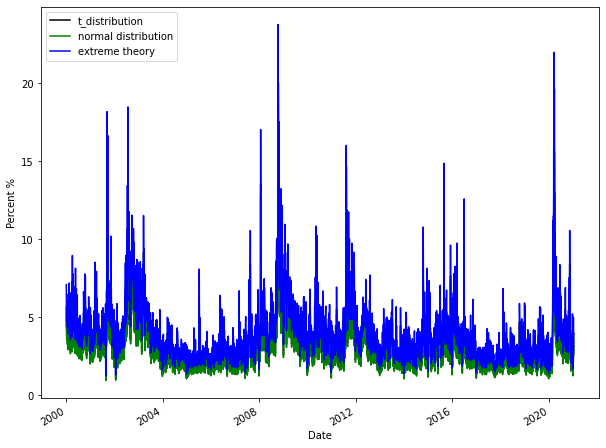

In [17]:
#plot the VaR
VaR_P = pd.DataFrame(index=['t_distribution','normal distribution','extreme theory'],
                     data=[VaR_t_return,VaR_n_return,VaR_e_return]).T

plt.figure(figsize=(10, 8))
VaR_P['t_distribution'].plot(color='black',legend='True')
VaR_P['normal distribution'].plot(color='green',legend='True')
VaR_P['extreme theory'].plot(color='blue',legend='True',ylabel='Percent %')

plt.show()

In [18]:
#work out the fraction of VaR
exc_t = pd.Series(R[1:]<-VaR_t_return).sum()
T = len(R)-1
exct_ratio = exc_t / T
exc_n = pd.Series(R[1:]<-VaR_n_return).sum()
T = len(R)-1
excn_ratio = exc_n / T
exc_e = pd.Series(R[1:]<-VaR_e_return).sum()
T = len(R)-1
exce_ratio = exc_e / T
print('percentage of exceedences from t-distribution',round(exct_ratio,4))
print('percentage of exceedences from normal distribution', round(excn_ratio,4))
print('percentage of exceedences from EVT theory',round(exce_ratio,4))

percentage of exceedences from t-distribution 0.0136
percentage of exceedences from normal distribution 0.0181
percentage of exceedences from EVT theory 0.0045


Discussion of results [15 pts]: 

Compared to the standard normal distribution, the standardized T-distribution has a better fit which percentage of exceedences is more closed to 1%, but still has more exceedences than presumed. The EVT theory is too strict in practice with the percentage of exceedence of  0.4%,much smaller than 1%. 
Besides, compared with the VaR backtest results with constant volatility, time-varying volatility's result is a little bit better,which is more closed to the significant level(1%) In general,we could use stress testing and scenarios to test the time-varing and constant volatility model in extreme situations in which heavy loss happens in a higher frequancy.